In [64]:
from commonfunctions import *
from skimage import io
from skimage.color import rgba2rgb, rgb2gray
from skimage import filters
from skimage.feature import hog
import numpy as np
import cv2
import sys
import os
from PHOG import *
from Faces import *
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn import svm
import pickle

In [65]:
imgs = []
labels = []

In [66]:
def ReadFile(path,label,imgs,labels):
    files = os.listdir(path)
    num_images = len(files)
    count = 0
    for f in files:
        img = io.imread(os.path.join(path, f), as_gray=False)
        if len(img.shape) != 2:
            img = rgb2gray(img)
        # img = cv2.resize(img, dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
        imgs.append(img)
        labels.append(label)
        count += 1
        if count>=100:
            return

In [67]:
ReadFile("./train/happy","happy",imgs,labels)
ReadFile("./train/sad","sad",imgs,labels)
ReadFile("./train/neutral","neutral",imgs,labels)
# ReadFile("./train/fearful","fear",imgs,labels)
# ReadFile("./train/surprised","surprise",imgs,labels)
ReadFile("./train/happy","happy",imgs,labels)
ReadFile("./train/sad","sad",imgs,labels)
# ReadFile("./train/fearful","fear",imgs,labels)
ReadFile("./train/neutral","neutral",imgs,labels)
# ReadFile("./train/surprised","surprise",imgs,labels)
ReadFile("./train/happy","happy",imgs,labels)
ReadFile("./train/sad","sad",imgs,labels)
ReadFile("./train/neutral","neutral",imgs,labels)

In [68]:
print(len(imgs))
print(len(labels))

900
900


In [69]:
def LPQ(img, window = 3): 
    # img = fftpack.fft2(img)
    # img_ft = np.fft.fftshift(img_ft)
    # img = np.divide(img, np.sum(img))
    lpq_hist = np.zeros((0))
    patch_height = patch_width = window
    w = img.shape[0]
    h = img.shape[1]
    block1 = img[0:(w//2), 0:h//2]
    block2 = img[(w//2):w, 0:h//2]
    block3 = img[0:(w//2), (h//2):h]
    block4 = img[(w//2):w, (h//2):h]
    block_list = [block1,block2,block3,block4]
    mid = window // 2
    count = 0
    for block in block_list:
        block_w, block_h= block.shape
        block_hist = np.zeros(256)
        for i in range (patch_width , block_w-patch_width):
            for j in range (patch_height, block_h - patch_width):
                temp = 0
                patch = block[i - mid : i + mid + 1 , j - mid : j + mid + 1]
                patch = np.fft.fft2(patch)
                patch = np.fft.fftshift(patch)
                if(np.imag(patch[mid-1][mid]) > 0):
                    temp += 1
                if(np.real(patch[mid-1][mid])> 0):
                    temp += 2
                if(np.imag(patch[mid][0])> 0):
                    temp += 4
                if(np.real(patch[mid][0])> 0):
                    temp += 8
                if(np.imag(patch[mid][mid-1])> 0):
                    temp += 16
                if(np.real(patch[mid][mid-1])> 0):
                    temp += 32
                if(np.imag(patch[mid-2][mid-1])> 0):
                    temp += 64
                if(np.real(patch[mid-2][mid-1])> 0):
                    temp += 128
                # lpq_hist.append(temp)
                block_hist[temp] += 1
        block_hist = block_hist.astype('uint8')
        lpq_hist = np.append(lpq_hist,block_hist)
    return lpq_hist

In [70]:
cnt=  0
features_3 = []
for img in imgs:
    phog = PHOG(img, 40, 3)
    lpq = LPQ(img,3)
    temp = np.concatenate((phog, lpq))
    features_3.append(temp)
    cnt += 1
    if(cnt % 100 == 0):
        print(cnt)
features_3 = np.array(features_3)

100
200
300
400
500
600
700
800
900


In [71]:
cnt=  0
features_phog = []
for img in imgs:
    phog = PHOG(img, 40, 3)
    features_phog.append(phog)
    cnt += 1
    if(cnt % 100 == 0):
        print(cnt)
features_phog = np.array(features_phog)

100
200
300
400
500
600
700
800
900


In [72]:
labels = np.array(labels)
labels[labels=="happy"] = 1
labels[labels=="sad"] = 2
labels[labels=="angry"] = 3
labels[labels=="fear"] = 4
labels[labels=="surprise"] = 3
labels[labels=="neutral"] = 5
labels = labels.astype('int32')

In [73]:
x_train, x_test, y_train, y_test = train_test_split(features_3, labels, test_size=0.2,stratify=labels)

# pca = PCA(n_components=110)
# x_train = pca.fit_transform(x_train)
clf3 = svm.SVC()
model = clf3.fit(x_train, y_train)

# new = pca.transform(features_2[0].reshape((1, -1)))
# x_test = pca.fit_transform(x_test)
pred = clf3.predict(x_test)
acc = (np.sum(y_test == pred) / len(y_test))*100
print(f'Accuracy when using PHOG + LPQ : {acc} %')
print(x_test.shape)
# target_names = ['happy', 'sad', 'angry', 'fear', 'surprise']
# print(classification_report(y_test, pred, target_names=target_names))

Accuracy when using PHOG + LPQ : 66.66666666666666 %
(180, 1864)


In [74]:
# x_test = []
# y_test = []
# faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# def getCroppedFaces(faceimg):
#     # colorB = np.copy(faceimg[:,:,0])
#     # colorR = np.copy(faceimg[:,:,2])
#     # faceimg[:,:,0] = colorR
#     # faceimg[:,:,2] = colorB
#     faces = faceCascade.detectMultiScale(faceimg,minNeighbors=5)
#     Cropped_faces = []
#     for face in faces:
#         Cropped_faces.append(np.copy(faceimg[face[1]:face[1]+face[3],face[0]:face[0]+face[2],:]))
#     return Cropped_faces[0]

# for i in range(1,2):
#     tempimg = io.imread('Images/'+str(i)+'.jpg')
#     tempimg = getCroppedFaces(tempimg)
#     tempimg = rgb2gray(tempimg)
#     tempimg = cv2.resize(tempimg, dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
#     phog = PHOG(tempimg, 40, 3)
#     lpq = LPQ(tempimg,3)
#     temp = np.concatenate((phog, lpq))
#     x_test.append(temp)

# # show_images(x_test)
# y_test = ["happy", "sad", "happy","sad", "happy", "happy","happy"]
# x_test = np.array(x_test)


In [75]:
# print(clf3.predict(x_test))

In [76]:
x_train, x_test, y_train, y_test = train_test_split(features_phog, labels, test_size=0.2,stratify=labels)

# pca = PCA(n_components=150)
# features_new = pca.fit(x_train)
clf = svm.SVC(kernel='rbf')
model = clf.fit(x_train, y_train)

# new = pca.transform(features_2[0].reshape((1, -1)))
pred = clf.predict(x_test)
acc = (np.sum(y_test == pred) / len(y_test))*100
print(f'Accuracy when using only PHOG: {acc} %')

Accuracy when using only PHOG: 65.0 %


In [77]:
def getFeatureArray(size = 24):
    feature_array = []
    loop_on_array = np.zeros((size,size))
    feature_names = ["Edge_Horizontal","Edge_Vertical","Line_Horizontal","Line_Verticle","Rectangle"]
    for name in feature_names:
                
        if name == "Edge_Horizontal":
            width = 1
            height = 0
            while not(width >= size and height >= size):
                for i in range(size - width):
                    for j in range(size - height):
#                         print((i,j),(i + width,j + height))
                        feature_array.append([(i,j),(i + width,j + height),name])
#                 print(len(feature_array), width, height)
#                 input()
                if width < size:
                    width += 2
                elif height != size:
                    width = 1
                    height += 1

        elif name == "Edge_Vertical":
            width = 0
            height = 1
            while not(width >= size and height >= size):
                for i in range(size - width):
                    for j in range(size - height):
#                         print((i,j),(i + width,j + height))
                        feature_array.append([(i,j),(i + width,j + height),name])
                if height < size:
                    height += 2
                elif width != size:
                    height = 1
                    width += 1

        elif name == "Line_Horizontal":
            width = 2
            height = 0
            while not(width >= size and height >= size):
                for i in range(size - width):
                    for j in range(size - height):
#                         print((i,j),(i + width,j + height))
                        feature_array.append([(i,j),(i + width,j + height),name])
                if width < size:
                    width += 3
                elif height != size:
                    width = 2
                    height += 1     
                    
        elif name == "Line_Verticle":
            width = 0
            height = 2
            while not(width >= size and height >= size):
                for i in range(size - width):
                    for j in range(size - height):
#                         print((i,j),(i + width,j + height))
                        feature_array.append([(i,j),(i + width,j + height),name])
                if height < size:
                    height += 3
                elif width != size:
                    height = 2
                    width += 1  

        elif name == "Rectangle":
            width = 1
            height = 1
            while not(width >= size and height >= size):
                for i in range(size - width):
                    for j in range(size - height):
                        feature_array.append([(i,j),(i + width,j + height),name])
                if width < size:
                    width += 2
                elif height != size:
                    width = 1
                    height += 2

    return feature_array

feature_array = getFeatureArray(24)
print(len(feature_array))

162336


In [78]:
def preprocessImg(img):
    img_copy = np.copy(img)
    if len(img_copy.shape) != 2:
        img_copy = rgb2gray(img_copy)
    img_copy = cv2.resize(img_copy, dsize=(24, 24), interpolation=cv2.INTER_CUBIC) 
    return img_copy

In [79]:
def getIntegralImage(img):
    new_img = np.zeros(img.shape)
#     new_img[i,j] = img[0,0]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img[i,j] = np.sum(img[0:i+1,0:j+1])
    return new_img

In [80]:
def calculateSumOfIntegralImage_V2(int_img,st_x,st_y,end_x,end_y):
        if (st_x-1 < 0) or (st_y-1) < 0:
            return int_img[end_x,end_y]
        if (end_x == 24):
            end_x -= 1
        if (end_y == 24):
            end_y -= 1
        if (st_x - 1 == 24):
            st_x -= 2
        if (st_y - 1 == 24):
            st_y -= 2
        # print(int_img.shape,st_x,st_y,end_x,end_y)
        return int_img[end_x,end_y] + int_img[st_x-1,st_y-1] - int_img[end_x,st_y-1] - int_img[st_x-1,end_y]

In [81]:
def harrEdgeHorizontal(int_img,feature_params, scale_factor):
    # print(feature_params)
    st_x, st_y = feature_params[0] 
    end_x, end_y = feature_params[1] 
    st_x = int(st_x * scale_factor)
    st_y = int(st_y * scale_factor)
    end_x = int(end_x * scale_factor)
    end_y = int(end_y * scale_factor)
    middle_x = (end_x + st_x)//2
    middle_y = (end_y + st_y)//2
    up_value = calculateSumOfIntegralImage_V2(int_img,st_x,st_y,middle_x,end_y)
    down_value = calculateSumOfIntegralImage_V2(int_img,middle_x + 1,st_y,end_x,end_y)
    return up_value - down_value

In [82]:
def harrEdgeVerticle(int_img,feature_params, scale_factor):
    # print(feature_params)
    st_x, st_y = feature_params[0] 
    end_x, end_y = feature_params[1] 
    st_x = int(st_x * scale_factor)
    st_y = int(st_y * scale_factor)
    end_x = int(end_x * scale_factor)
    end_y = int(end_y * scale_factor)
    middle_x = (end_x + st_x)//2
    middle_y = (end_y + st_y)//2
    left_value = calculateSumOfIntegralImage_V2(int_img,st_x,st_y,end_x,middle_y)
    right_value = calculateSumOfIntegralImage_V2(int_img,st_x,middle_y + 1,end_x,end_y)
    return left_value - right_value

In [83]:
def harrLineHorizontal(int_img,feature_params, scale_factor):
    # print(feature_params)
    st_x, st_y = feature_params[0]
    end_x, end_y = feature_params[1] 
    st_x = int(st_x * scale_factor)
    st_y = int(st_y * scale_factor)
    end_x = int(end_x * scale_factor)
    end_y = int(end_y * scale_factor)
    third_x = (end_x + st_x + st_x)//3
    third_2x = (end_x + end_x + st_x)//3
    third_y = (end_y + st_y + st_y)//3
    third_2y = (end_y + end_y + st_y)//3
#     print("st_x,st_y,third_x,third_y,third_2x,third_2y,end_x,end_y")
#     print(st_x,st_y,third_x,third_y,third_2x,third_2y,end_x,end_y)
    up_value = calculateSumOfIntegralImage_V2(int_img,st_x,st_y,third_x,end_y)
    middle_value = calculateSumOfIntegralImage_V2(int_img,third_x + 1,st_y,third_2x,end_y)
    down_value = calculateSumOfIntegralImage_V2(int_img,third_2x + 1,st_y,end_x,end_y)
    return up_value + down_value - middle_value

In [84]:
def harrLineVerticle(int_img,feature_params, scale_factor):
    # print(feature_params)
    st_x, st_y = feature_params[0] 
    end_x, end_y = feature_params[1] 
    st_x = int(st_x * scale_factor)
    st_y = int(st_y * scale_factor)
    end_x = int(end_x * scale_factor)
    end_y = int(end_y * scale_factor)
    third_x = (end_x + st_x + st_x)//3
    third_2x = (end_x + end_x + st_x)//3
    third_y = (end_y + st_y + st_y)//3
    third_2y = (end_y + end_y + st_y)//3
    left_value = calculateSumOfIntegralImage_V2(int_img,st_x,st_y,end_x,third_y)
    middle_value = calculateSumOfIntegralImage_V2(int_img,st_x,third_y + 1,end_x,third_2y)
    right_value = calculateSumOfIntegralImage_V2(int_img,st_x,third_2y + 1,end_x,end_y)
    return left_value + right_value - middle_value

In [85]:
def harrRectangle(int_img,feature_params,scale_factor):
    # print(feature_params)
    # try:
        st_x, st_y = feature_params[0]
        end_x, end_y = feature_params[1] 
        st_x = int(st_x * scale_factor)
        st_y = int(st_y * scale_factor)
        end_x = int(end_x * scale_factor)
        end_y = int(end_y * scale_factor)
        middle_x = (end_x + st_x)//2
        middle_y = (end_y + st_y)//2
        up_left_value = calculateSumOfIntegralImage_V2(int_img,st_x,st_y,middle_x,middle_y)
        up_right_value = calculateSumOfIntegralImage_V2(int_img,st_x,middle_y + 1,middle_x,end_y)
        down_left_value = calculateSumOfIntegralImage_V2(int_img,middle_x + 1,st_y,end_x,middle_y)
        down_right_value = calculateSumOfIntegralImage_V2(int_img,middle_x + 1,middle_y + 1,end_x,end_y)
#         print(up_left_value,up_right_value,down_left_value,down_right_value,up_left_value + down_right_value - up_right_value - down_left_value)
        return up_left_value + down_right_value - up_right_value - down_left_value
    # except:
        # print(feature_params)

In [86]:
def calculateHaar(int_img,feature_params, scale_factor):
    # try:
        if feature_params[2] == "Edge_Horizontal":
            return harrEdgeHorizontal(int_img,feature_params[0:2],scale_factor)
        elif feature_params[2] == "Edge_Vertical":
            return harrEdgeVerticle(int_img,feature_params[0:2],scale_factor)
        elif feature_params[2] == "Line_Horizontal":
            return harrLineHorizontal(int_img,feature_params[0:2],scale_factor)
        elif feature_params[2] == "Line_Verticle":
            return harrLineVerticle(int_img,feature_params[0:2],scale_factor)
        elif feature_params[2] == "Rectangle":
            return harrRectangle(int_img,feature_params[0:2],scale_factor)
    # except:
        # print(feature_params)
        # print(feature_params[0] * scale_factor)

In [87]:
# stage # feature # values
learned = np.zeros((100,10,4))
count = 10
for i in range(100):
    with open('./Trained/filename'+ str(count) +'.txt') as f:
        lines = f.readlines()
        for j in range(10):
            learned[i][j][0] = int(lines[j * 4])
            learned[i][j][1] = float(lines[j * 4 + 1])
            learned[i][j][2] = float(lines[j * 4 + 2])
            learned[i][j][3] = int(lines[j * 4 + 3]) 
        count += 1

In [88]:
def predictStamb(int_img,featue,thrs,more,feature_array,scale):
    try:
        res = calculateHaar(int_img,feature_array[int(featue)],scale)
        if (res >= thrs and more == True) or (res < thrs and more == False):
            return 1
        else:
            return 0
    except:
        print(int_img.shape)
        print(feature_array[int(featue)])
        print(scale)
        print(calculateHaar(int_img,feature_array[int(featue)],scale))
    #     print(int_img.shape)
    #     print(feature_array[int(featue)])
    #     print(scale)
    #     print(calculateHaar(int_img,feature_array[int(featue)],scale))

In [89]:
def predictAdaBoost(int_img,learned,index,feature_array,scale):
    preds = []
    for i in range(learned[index].shape[0]):
        preds.append(learned[index][i][1] * predictStamb(int_img,learned[index][i][0],learned[index][i][2],learned[index][i][3],feature_array,scale))  
    pred = np.sum(preds)
    pred = np.sign(pred)
    return pred  

In [90]:
def slideWindow(test_img, learned, feature_array):
    winX = 24
    winY = 24
    scale = 1
    results = []
    score = -9999999999999
    while (winX < test_img.shape[0]) and (winY < test_img.shape[1]): 
        # print(winX,winY)
        for i in range(0,int(test_img.shape[0] - winX),1):
            for j in range(0,int(test_img.shape[1] - winY),1):
                # print(i , int(i+winX) ,j ,int(j + winY))
                if(i + winX > test_img.shape[0] or j + winY > test_img.shape[1]):
                    break
                croppedImg = np.copy(test_img[i:int(i+winX),j:int(j+winY)])
                int_img = getIntegralImage(croppedImg)
                val = 0
                for i in range(0,learned.shape[0]):
                    val += predictAdaBoost(int_img,learned,i,feature_array,scale)
                    # print(i,val)
                # print(val)
                if val >= score:
                    if val != score:
                        results = []
                    score = val
                    results.append(croppedImg)
        scale = scale * 1.25
        winX *= 1.25
        winY *= 1.25
        # print("I am here")
    return results

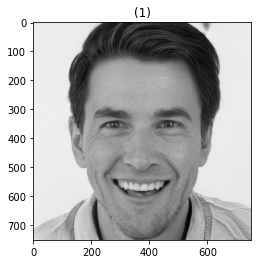

(750, 750)


In [91]:
test_img = io.imread("1.jpg")
test_img = rgb2gray(test_img)
show_images([test_img])
print(test_img.shape)

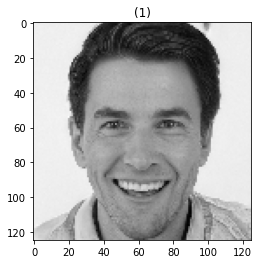

(125, 125)


In [92]:
test_img2 = cv2.resize(test_img, dsize=(int(test_img.shape[0] / 6), int(test_img.shape[1] / 6)), interpolation=cv2.INTER_CUBIC) 
show_images([test_img2])
print(test_img2.shape)

In [93]:
result = slideWindow(test_img2,learned,feature_array)

26


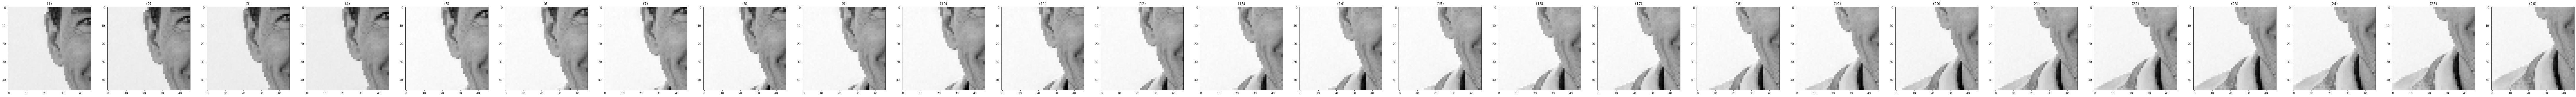

In [94]:
print(len(result))
show_images(result)

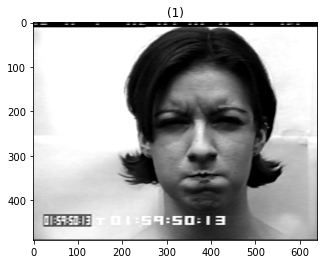

(490, 640)


In [95]:
test_img = io.imread("p1.png")
# test_img = rgb2gray(test_img)
show_images([test_img])
print(test_img.shape)

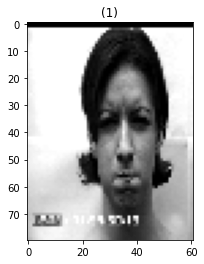

(80, 61)


In [96]:
test_img2 = cv2.resize(test_img, dsize=(int(test_img.shape[0] / 6), int(test_img.shape[1] / 6)), interpolation=cv2.INTER_CUBIC) 
show_images([test_img2])
print(test_img2.shape)

In [97]:
result = slideWindow(test_img2,learned,feature_array)

21


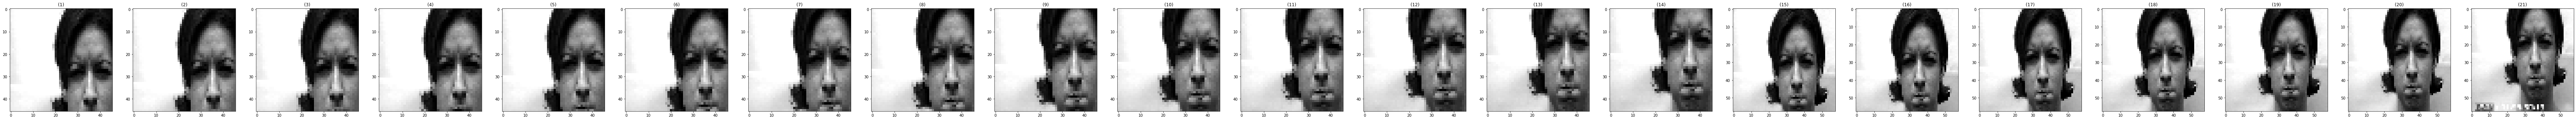

In [98]:
print(len(result))
show_images(result)

In [99]:
phog = PHOG(result[int(len(result)/2)], 40, 3)
lpq = LPQ(result[int(len(result)/2)],3)
temp = np.concatenate((phog, lpq))
prediction = clf3.predict([temp])
print(prediction)

ValueError: X has 2224 features, but SVC is expecting 1864 features as input.